# connect to the Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00


# Import libraries

In [4]:
import numpy as np
import cv2
import os
from mtcnn import MTCNN
from google.colab.patches import cv2_imshow
from collections import Counter
import pandas as pd
import re
import ast
import dlib
from PIL import Image
from keras.preprocessing import image
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

# Definition of functions

In [10]:
def apply_sobel_filter(gray_image):
    height = len(gray_image)
    width = len(gray_image[0])

    Gx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    Gy = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

    sobel_image = [[0] * width for _ in range(height)]

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            gx = sum(Gx[x][y] * gray_image[i + x - 1][j + y - 1] for x in range(3) for y in range(3))
            gy = sum(Gy[x][y] * gray_image[i + x - 1][j + y - 1] for x in range(3) for y in range(3))
            sobel_image[i][j] = min(255, int((gx ** 2 + gy ** 2) ** 0.5))

    return sobel_image


def detect_lines(sobel_image):
    height = len(sobel_image)
    width = len(sobel_image[0])

    lines = []
    for i in range(height):
        for j in range(width):
            if sobel_image[i][j] > 128:
                lines.append((i, j))

    return lines


def filter_eye_region_by_area(face, lines, image_height, image_width):
    eye_lines = []
    y1 = face[0][1] + ((face[0][3]) / 4)
    y2 = face[0][1] + ((face[0][3]) / 2)
    left_limit = face[0][0] + ((face[0][2]) / 6)
    right_limit = face[0][0] + 7 * ((face[0][2]) / 8)

    for (x, y) in lines:
        if int(y1) < x < int(y2) and left_limit < y < right_limit:
            eye_lines.append((x, y))

    return eye_lines


def filter_by_shape_and_size(lines):
    eye_lines = []
    for (x, y) in lines:
        if 110 < x < 120:
            eye_lines.append((x, y))
    return eye_lines


def is_skin_color(r, g, b):
    is_brownish = (r > 95 and r < 255 and g > 40 and g < 200 and b < 150)
    is_pinkish = (r > 160 and g > 50 and g < 150 and b > 100)
    is_pinkish2 = (187 <= r <= 207 and 155 <= g <= 175 and 144 <= b <= 164)

    return (is_brownish or is_pinkish or is_pinkish2)


def is_color_similar_to_skin(color, skin_color, threshold=80):
    return all(abs(color[i] - skin_color[i]) < threshold for i in range(3))


def extract_eye_colors(image, eye_lines, skin_color):
    eye_colors = []
    for (x, y) in eye_lines:
        r, g, b = image[x, y]
        brightness_threshold = 200
        if not is_skin_color(b, g, r) and (r + g + b) < brightness_threshold:
            current_color = (b, g, r)
            if not is_color_similar_to_skin(current_color, skin_color):
                eye_colors.append(current_color)
    return eye_colors


def find_dominant_color(colors):
    if not colors:
        return None

    color_counter = Counter(colors)
    dominant_color = color_counter.most_common(1)[0][0]
    return dominant_color


def find_eyes(image, face):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_image = apply_sobel_filter(gray)
    lines = detect_lines(sobel_image)
    eye_lines = filter_eye_region_by_area(face, lines, len(image), len(image[0]))
    eye_lines = filter_by_shape_and_size(eye_lines)
    return eye_lines


def draw_eye_lines(image, eye_lines):
    for (x, y) in eye_lines:
        cv2.circle(image, (y, x), 2, (0, 255, 0), -1)
    return image


def process_image(idx, image_file):

    # if (idx + 1) % 100 == 0:
    #     print(f'Processed {idx + 1} images...')

    image_path = os.path.join(processed_images_path, image_file)
    image = cv2.imread(image_path)
    if image is None:
        print(f'Error loading image {image_file}')
        return None, None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return idx, None

    x, y, width, height = faces[0]
    face_region = image[y:y+height, x:x+width]
    ycrcb_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2YCrCb)
    skin_mask = cv2.inRange(ycrcb_face, lower_skin, upper_skin)
    skin_pixels = cv2.bitwise_and(face_region, face_region, mask=skin_mask)
    skin_pixels = skin_pixels[skin_mask > 0]

    if skin_pixels.size > 0:
        median_skin_color_bgr = np.median(skin_pixels, axis=0)
        median_skin_color_rgb = median_skin_color_bgr[::-1].astype(int)
        return idx, median_skin_color_rgb
    else:
        print(f'No skin pixels found for face at ({x}, {y}).')
        return idx, None

# detection of faces

In [ ]:
dataset_path = '/content/drive/MyDrive/samples'
processed_images_path = '/content/drive/MyDrive/processed_images_samples'
os.makedirs(processed_images_path, exist_ok=True)

detector = MTCNN()

image_files = [f for f in os.listdir(dataset_path) if f.endswith(('jpg', 'jpeg', 'png'))]

mismatch_detected = False

# detection of faces and storing images
for image_file in image_files:
    image_path = os.path.join(dataset_path, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(image_rgb)

    # Checking the number of identified faces
    if len(faces) != 1:
        print(f"Image: {image_file}, Faces detected: {len(faces)}")
        mismatch_detected = True

    # Draw a rectangle on the identified faces
    for face in faces:
        x, y, width, height = face['box']
        cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)

    cv2.imwrite(os.path.join(processed_images_path, image_file), image)

if not mismatch_detected:
    print("All face detections are correct, exactly 1 face detected in all images.")


All face detections are correct, exactly 1 face detected in all images.


# Facial Landmark Detection algorithm

Exactly 1 face detected in the image '/content/drive/MyDrive/samples/050016.jpg'


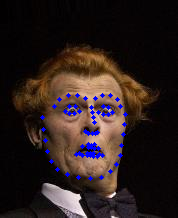

In [ ]:
predictor_path = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"
image_path = "/content/drive/MyDrive/samples/050016.jpg"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = detector(gray)

if len(faces) != 1:
    print(f"Warning: Detected {len(faces)} faces in the image '{image_path}'")
else:
    print(f"Exactly 1 face detected in the image '{image_path}'")

for face in faces:
    landmarks = predictor(gray, face)

    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        cv2.circle(image, (x, y), 2, (255, 0, 0), -1)

# output_image_path = "/content/drive/MyDrive/processed_images_sample/000093_with_landmarks.jpg"
# cv2.imwrite(output_image_path, image)

from google.colab.patches import cv2_imshow
cv2_imshow(image)


# finding skin color

In [ ]:
processed_images_path = '/content/drive/MyDrive/dataset'
csv_path = '/content/drive/MyDrive/features.csv'
output_csv_path = '/content/drive/MyDrive/features_with_colors.csv'
df = pd.read_csv(csv_path)

if 'skin_color' not in df.columns:
    df['skin_color'] = None

image_files = [f for f in os.listdir(processed_images_path) if f.endswith(('jpg', 'jpeg', 'png'))][:50000]

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Definition of skin color range in YCrCb space
lower_skin = np.array([0, 133, 77], dtype=np.uint8)
upper_skin = np.array([255, 173, 127], dtype=np.uint8)

# parallel execution
with ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda i: process_image(i[0], i[1]), enumerate(image_files)))

for idx, skin_color in results:
    if idx is not None and idx < len(df):
        df.at[idx, 'skin_color'] = skin_color

df.to_csv(output_csv_path, index=False)


Processed 100 images...
No skin pixels found for face at (33, 68).
Processed 200 images...
Processed 300 images...
Processed 400 images...
No skin pixels found for face at (49, 83).
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
No skin pixels found for face at (34, 70).
Processed 900 images...
Processed 1000 images...
Processed 1100 images...
Processed 1200 images...
Processed 1300 images...
No skin pixels found for face at (41, 71).
Processed 1400 images...
No skin pixels found for face at (30, 66).
Processed 1500 images...
No skin pixels found for face at (39, 76).
Processed 1600 images...
Processed 1700 images...
Processed 1800 images...
Processed 1900 images...
Processed 2000 images...
Processed 2100 images...
Processed 2200 images...
Processed 2300 images...
Processed 2400 images...
Processed 2500 images...
Processed 2600 images...
Processed 2700 images...
Processed 2800 images...
Processed 2900 images...
Processed 3000 images...
P

# finding eye & skin color with multi threding

In [ ]:
processed_images_path = '/content/drive/MyDrive/dataset'
csv_path = '/content/drive/MyDrive/features.csv'
counter = 1

df = pd.read_csv(csv_path)

if 'eye_color' not in df.columns:
    df['eye_color'] = None

image_files = [f for f in os.listdir(processed_images_path) if f.endswith(('jpg', 'jpeg', 'png'))][2001:2010]
image_files.sort()
df = df.sort_values(by='image_id')

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

lower_skin = np.array([0, 133, 77], dtype=np.uint8)
upper_skin = np.array([255, 173, 127], dtype=np.uint8)


def process_image(idx, image_file):
    global counter  # Declare counter as global within the function
    print(counter)
    counter += 1
    image_path = os.path.join(processed_images_path, image_file)
    image = cv2.imread(image_path)
    if image is None:
        print(f'Error loading image {image_file}')
        return idx, None, None  # Return idx, None, None for consistency

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    median_skin_color_rgb = None
    eye_colors = []
    if len(faces) > 0 :
      for (x, y, w, h) in faces:
          cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

          face_region = image[y:y+h, x:x+w]
          ycrcb_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2YCrCb)
          skin_mask = cv2.inRange(ycrcb_face, lower_skin, upper_skin)

          skin_pixels = cv2.bitwise_and(face_region, face_region, mask=skin_mask)
          skin_pixels = skin_pixels[skin_mask > 0]

          if skin_pixels.size > 0:
              median_skin_color_bgr = np.median(skin_pixels, axis=0)
              median_skin_color_rgb = median_skin_color_bgr[::-1].astype(int)
          else:
              print(f'No skin pixels found for face at ({x}, {y}).')
              median_skin_color_rgb = np.array([128, 128, 128])

      eye_lines = find_eyes(image, faces)

      eye_colors = extract_eye_colors(image, eye_lines, median_skin_color_rgb)

      dominant_eye_color = find_dominant_color(eye_colors)

      if dominant_eye_color is not None:
          dominant_eye_color_list = list(dominant_eye_color)
      else:
          dominant_eye_color_list = [120, 112, 105]

      return idx, median_skin_color_rgb, dominant_eye_color_list

    return idx, None, None

skin_colors = []
eye_colors = []

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(lambda i: process_image(i[0], i[1]), enumerate(image_files)))

for idx, skin_color, eye_color in results:
    if idx is not None:
        df.at[idx, 'eye_color'] = eye_color

output_csv_path = '/content/drive/MyDrive/features_with_colors_final.csv'
df.to_csv(output_csv_path, index=False)

1
2
3
4
55
6

77



<ipython-input-9-fc9310d28615>:71: RuntimeWarning: overflow encountered in scalar add
  if not is_skin_color(b, g, r) and (r + g + b) < brightness_threshold:


# finding skin & eye color

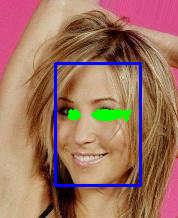

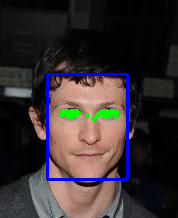

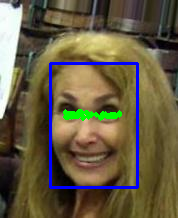

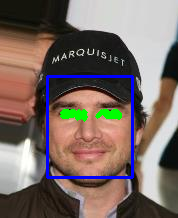

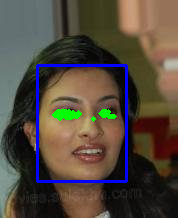

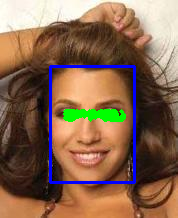

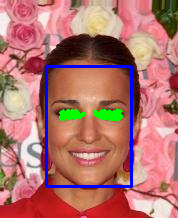

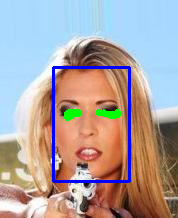

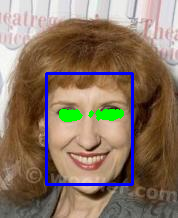

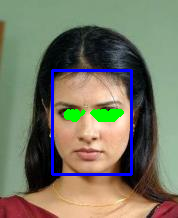

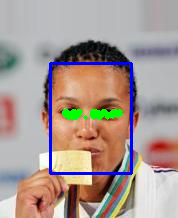

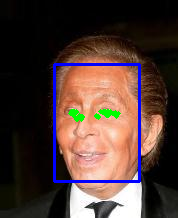

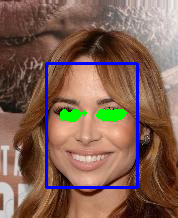

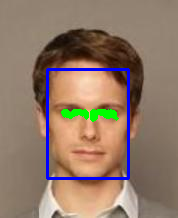

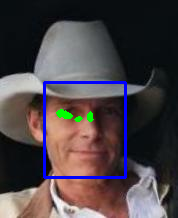

KeyboardInterrupt: 

In [11]:
processed_images_path = '/content/drive/MyDrive/test'
csv_path = '/content/drive/MyDrive/test_features.csv'

df = pd.read_csv(csv_path)

if 'eye_color' not in df.columns:
    df['eye_color'] = None
if 'skin_color' not in df.columns:
    df['skin_color'] = None

image_files = [f for f in os.listdir(processed_images_path) if f.endswith(('jpg', 'jpeg', 'png'))]
image_files.sort()
df = df.sort_values(by='image_id')

skin_colors = []
eye_colors = []

detector = MTCNN()

# detection of faces
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(processed_images_path, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    faces = detector.detect_faces(image_rgb)

    for face in faces:
        # face coordinates
        x, y, width, height = face['box']
        cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)

    # Definition of skin color range in YCrCb space
    lower_skin = np.array([0, 133, 77], dtype=np.uint8)
    upper_skin = np.array([255, 173, 127], dtype=np.uint8)

    median_skin_color = None

    if len(faces) > 0:
      faces = [faces[0]['box']]
    else:
      faces = []

    # Processing of recognized faces
    for (x, y, w, h) in faces:
        face_region = image[y:y+h, x:x+w]
        ycrcb_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2YCrCb)
        skin_mask = cv2.inRange(ycrcb_face, lower_skin, upper_skin)

        # Extraction of the skin area
        skin_pixels = cv2.bitwise_and(face_region, face_region, mask=skin_mask)

        # convert skin area to one-dimensional array
        skin_pixels = skin_pixels[skin_mask > 0]

        # median skin color
        if skin_pixels.size > 0:
            median_skin_color_bgr = np.median(skin_pixels, axis=0)
            median_skin_color_bgr = median_skin_color_bgr.astype(int)
            median_skin_color_rgb = median_skin_color_bgr[::-1]
            skin_colors.append(median_skin_color_rgb)
        else:
            print(f'No skin pixels found for face at ({x}, {y}).')
            skin_colors.append(None)

    if len(faces) > 0:
      eye_lines = find_eyes(image,faces)

    image_with_eyes = draw_eye_lines(image, eye_lines)
    cv2_imshow(image_with_eyes)

    # Extracting the colors of the eye area by filtering the whites
    eye_colors = extract_eye_colors(image, eye_lines,median_skin_color_rgb)

    # Finding the dominant color in the eye area
    dominant_eye_color = find_dominant_color(eye_colors)

    if dominant_eye_color is not None:
      dominant_eye_color_list = list(dominant_eye_color)
      eye_colors.append(dominant_eye_color_list)
      # print("Dominant eye color (RGB):", dominant_eye_color)
    else:
      eye_colors.append([120, 112, 105])
      # print("No dominant color found")

    df.at[idx, 'skin_color'] = skin_colors[-1] if skin_colors else None
    df.at[idx, 'eye_color'] = eye_colors[-1] if eye_colors else None

output_csv_path = '/content/drive/MyDrive/test_features_with_colors.csv'
df.to_csv(output_csv_path, index=False)


In [ ]:
csv_path = '/content/drive/MyDrive/features_with_colors(1).csv'
def add_commas_to_list(value):
    if isinstance(value, str):
        value = re.sub(r'(\d+)\s+(\d+)', r'\1, \2', value)
        value = re.sub(r'(\d+)\s+(\d+)', r'\1, \2', value)
    return value

def rgb_to_binary(rgb, threshold):
    r, g, b = rgb
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 1 if luminance > threshold else -1

df = pd.read_csv(csv_path)

df['skin_color'] = df['skin_color'].apply(add_commas_to_list)
df['skin_color'] = df['skin_color'].apply(lambda x: ast.literal_eval(x))
df['skin_color'] = df['skin_color'].apply(lambda x: rgb_to_binary(x, threshold=128))

df.to_csv('/content/drive/MyDrive/final_features.csv', index=False)

df = pd.read_csv('/content/drive/MyDrive/final_features.csv')

df['eye_color'] = df['eye_color'].apply(lambda x: ast.literal_eval(x))
df['eye_color'] = df['eye_color'].apply(lambda x: rgb_to_binary(x, threshold=150))

df.to_csv('/content/drive/MyDrive/final_features.csv', index=False)
